## 19 - Typography
>Map focused on typography. Let text and words do the heavy lifting today. Whether you’re focusing on place names, labeling, or using text to create shapes and patterns. ✍️🅰️

In [507]:
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.patheffects as path_effects
import numpy as np
import osmnx as ox
import shapely
from shapely import Polygon, LineString
from shapely.ops import unary_union, linemerge


In [ ]:
fonts = glob('../../../../../fonts/water-splash-script-font/*.otf')
font_manager.fontManager.addfont(fonts[1])
font_manager.fontManager.addfont('../../../../../fonts/entschuldigung-font/EntschuldigungRegular-Y5xy.ttf')

In [41]:
aoi = Polygon([
            [
              -0.06980478394575584,
              51.510098642307554
            ],
            [
              -0.1085445857334264,
              51.51325589130607
            ],
            [
              -0.11049726774893998,
              51.5054514511655
            ],
            [
              -0.07630364793291733,
              51.50014991743845
            ],
            [
              -0.06980478394575584,
              51.510098642307554
            ]
          ])

In [67]:
# get data
river = ox.features_from_polygon(aoi, tags={'waterway':'river'})
banks = ox.features_from_polygon(aoi, tags={'water':'river'})
bridges = ox.features_from_polygon(aoi, tags={'man_made': 'bridge'})

# merge river banks into single geometry
thames = gpd.GeoSeries(Polygon(unary_union(banks.geometry.tolist())
                       .intersection(aoi)
                       .exterior),
                       crs=banks.crs)

# merge river centrelines into single centreline
centre = gpd.GeoSeries(linemerge(unary_union(river.loc[river['name'] == 'River Thames',
                                             'geometry'].tolist())
                       .intersection(aoi)),
                       crs=river.crs)

# filter out bridges in aoi that don't intersect the river centreline
bridges = bridges.loc[bridges.intersects(centre.geometry[0])]

# reproject everything
thames = thames.to_crs(27700)
centre = centre.to_crs(27700)
bridges = bridges.to_crs(27700)

In [ ]:
# helpers
def text_along_path(text, curve, ax, **kwargs):
    '''
    plots `text` along the `curve` on axes (`ax`)
    `kwargs` passed to `ax.text()`
    
    curve is array of shape (n,2)
    doesn't do any checks.
    requires some fanangling to get spacing right
    '''
    if isinstance(curve, LineString):
        ls = curve
        _x, _y = ls.coords.xy
        curve = np.c_[_x, _y]
    
    text_length = len(text)

    text_points = ls.interpolate(np.linspace(0, 1, text_length),
                                 normalized=True)
    text_x = [p.x for p in text_points]
    text_y = [p.y for p in text_points]

    dydx = np.gradient(curve[:,1], curve[:,0])
    
    angles = np.degrees(np.arctan(np.interp(text_x, curve[:,0], dydx)))

    for x, y, angle, t in zip(text_x, text_y, angles, text):
        ax.text(x, y, t, rotation=angle, rotation_mode='anchor', **kwargs)

def get_long_edges(geom):
    x, y = geom.minimum_rotated_rectangle.exterior.coords.xy
    corners = shapely.points(np.c_[x,y])
    
    edge_lengths = []
    for c0, c1 in zip(corners, corners[1:]):
        edge_lengths.append(c0.distance(c1))

    edge_lengths.sort()
    long_edges = []

    for c0, c1 in zip(corners, corners[1:]):
        if c0.distance(c1) in edge_lengths[-2:]:
            long_edges.append(LineString([c0, c1]))
            
    return long_edges

def average_line(lss):
    
    l1, l2 = lss

    l1 = LineString([l1.interpolate(q/10, normalized=True) for q in range(10+1)])
    l2 = LineString([l2.interpolate(q/10, normalized=True) for q in range(10+1)])

    x1, y1 = l1.coords.xy
    x2, y2 = l2.reverse().coords.xy
    
    
    return LineString(np.c_[np.c_[x1, x2].mean(axis=1),
                            np.c_[y1, y2].mean(axis=1)])
    

In [ ]:
# random points in box
minx, miny, maxx, maxy = thames[0].bounds
xs = np.random.randint(minx, maxx, 5000)
ys = np.random.randint(miny, maxy, 5000)
points = thames[0].intersection(shapely.points(np.c_[xs, ys]))
points = gpd.GeoDataFrame(geometry=points, crs=27700)
points = points[~points.is_empty]
points['x'] = points.geometry.x
points['y'] = points.geometry.y
points['text'] = np.random.choice(list('RiverThames~~~'), len(points), replace=True)

Text(0.01, 0.01, 'river text / by:tlohde / © OpenStreetMap contributors')

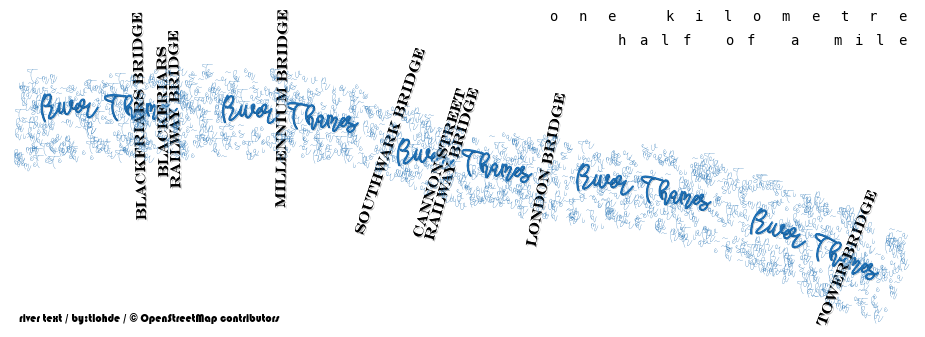

In [589]:
blue = plt.get_cmap('Blues')(0.75)

fig, ax = plt.subplots(figsize=[11.69, 8.27], subplot_kw={'aspect':'equal'})

_x, _y = centre[0].coords.xy
curve = np.c_[_x, _y]
dydx = np.gradient(curve[:,1], curve[:,0])

for frac in np.linspace(0.1, 0.9, 5):
    px, py = centre[0].interpolate(frac, normalized=True).coords.xy
    angle = np.degrees(np.arctan(np.interp(px, curve[:,0], dydx)))
    ax.annotate('River Thames',
                xy=(px[0], py[0]),
                ha='center',
                va='center',
                rotation=angle[0],
                font='Water Splash',
                size=20,
                # color='royalblue',
                path_effects=[
                    # path_effects.Stroke(linewidth=3.5, foreground='k'),
                    path_effects.Stroke(linewidth=1.2, foreground=blue),
                    path_effects.SimplePatchShadow(offset=(1,-1))
                              ],
                zorder=1)

for row in points.itertuples():
    ax.annotate(row.text,
                xy=(row.x, row.y),
                fontsize=10,
                font='Water Splash',
                color=blue,
                va='center',
                ha='center'
                )
    
for row in bridges.loc['way'].itertuples():
    long_edges = get_long_edges(row.geometry)
    middle = average_line(long_edges)
    # ax.plot(*middle.coords.xy)

    p0, p1 = middle.boundary.geoms
    c = middle.centroid
    ang = np.degrees(np.arctan2(p1.y-p0.y,
                                p1.x-p0.x))
    if ang < 0: ang += 180
    t = ax.annotate(row.name.replace('Railway Bridge', '\nRailway Bridge'),
                    xy=(c.x, c.y),
                    rotation=ang,
                    rotation_mode='anchor',
                    ha='center',
                    va='center',
                    font='Engravers MT',
                    zorder=2,
                    path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=0.5),
                                  path_effects.withSimplePatchShadow(offset=(1,-1)),
                                  path_effects.Normal()]
                    )

ax.set(xlim=(minx, maxx),
       ylim=(miny, maxy))

scale = LineString([
    [maxx - 40, maxy + 150],
    [maxx - 1040, maxy + 150]
    ])

text_along_path('one kilometre', scale.reverse(), ax,
                font='DejaVu Sans Mono',
                ha='center',
                va='center')

scale = LineString([
    [maxx - 40, maxy + 80],
    [maxx - 844, maxy + 80]
    ])

text_along_path('half of a mile', scale.reverse(), ax,
                font='DejaVu Sans Mono',
                ha='center',
                va='center')

ax.set_axis_off()

ax.annotate('river text / by:tlohde / © OpenStreetMap contributors',
            xy=(0.01, 0.01),
            xycoords='axes fraction',
            fontsize=8,
            font='Bauhaus 93')

In [590]:
fig.savefig('day19.png', bbox_inches='tight', dpi=300)